# Bypass the RL, win money 🤑

This notebook is a pipeline for designing an efficient model for AWS Deepracer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from copy import copy, deepcopy
from time import time
import sys
from multiprocessing import Pool
from IPython.display import clear_output

# Part 1 - Compute the optimal racing line

In [2]:
TRACK_NAME = 'Aragon'
NUMBER_STEPS_PER_SECOND = 15 

In [3]:
action_space = pd.DataFrame(columns = ['id', 'speed', 'steering'])
action_sequence = []
optimal_racing_line = pd.DataFrame(columns = ['x', 'y', 'speed', 'distance_from_last_point'])

### Load the appropriate Track

In [4]:
# Load the waypoints
waypoints = np.load("../tracks/" + TRACK_NAME + ".npy")

# Build the geometrical objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [5]:
def print_shape(ax, shape, color='cyan'):
    line = LineString(shape)
    x, y = line.xy                                                                
    ax.plot(x, y, '.', color='gray')   
    ax.plot(x, y, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2) 

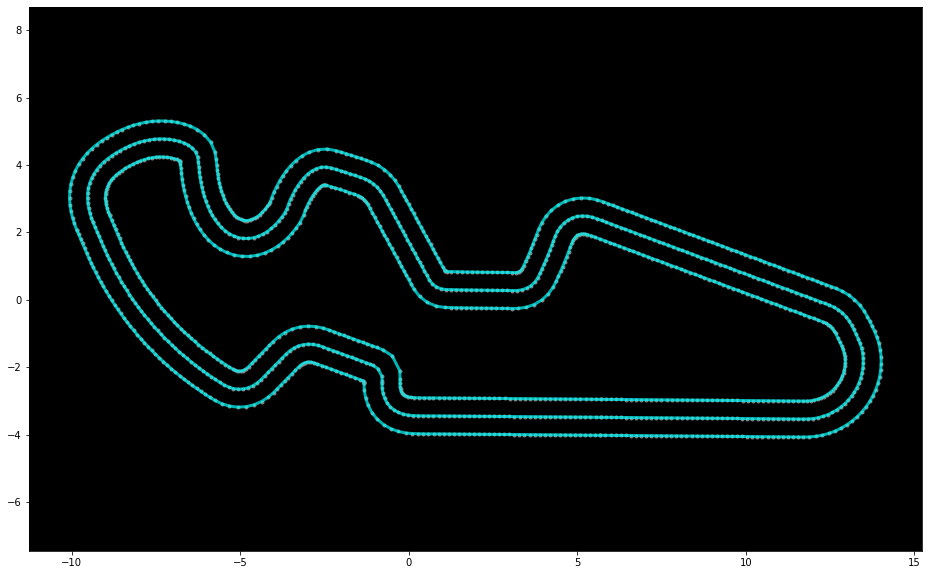

In [6]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)

# Part 2 - Compute the action space

# Part 3 - Compute the optimal racing line using only actions from the action space

### Mock (useful only for coding part 3 alone)

In [7]:
# Hardcoded action space to work with real values
action_space = [[0,-2.1672,1.8288], [1,4.7048,3.746], [2,-0.5041,2.631], [3,-8.4625,1.7638], [4,9.4065,1.3834], [5,4.8393,2.1362], [6,-2.4795,2.1993], [7,-1.2504,3.1708], [8,-5.5957,1.5737], [9,-0.4535,3.9733], [10,4.7458,1.8055], [11,7.6023,2.5505], [12,-3.6409,3.653], [13,0.2825,1.5781], [14,-12.393,1.5628], [15,-9.039,2.4206], [16,10.9898,1.7996], [17,30.0,1.33], [18,-30.0,1.33], [19,-0.9195,4.0], [20,0.0,4.0]]
action_space = pd.DataFrame(action_space, columns=('id','steering','speed'))

# # Mock racing line, to work with it
# optimal_racing_line = [[]]
# optimal_racing_line = pd.DataFrame(optimal_racing_line, columns=['x','y','speed','distance_from_last_point'])

### Utils

In [8]:
def compute_theta_from_coords(x0, x1, y0, y1):
    if x1 == x0:
        if y1 > y0:
            return np.pi / 2
        elif y1 < y0:
            return - np.pi / 2
        else:
            raise("Can't compute an angle when speed is null")
    elif x1 > x0:
        return np.arctan((y1-y0)/(x1-x0))
    else:
        return np.pi + np.arctan((y1-y0)/(x1-x0))

In [9]:
def take_theta_into_minus_pi_pi(theta):
    # Ensure rad_steering is between -pi and pi
    if theta > np.pi:
        return take_theta_into_minus_pi_pi(theta - 2 * np.pi)
    if theta < - np.pi:
        return take_theta_into_minus_pi_pi(theta + 2 * np.pi)
    else:
        return theta

### Compute action sequence

### Easiest method : compute the 'closest action' (lowest  euclidian distance) for each step

In [10]:
# # Note: to compute an effective euclidian distance, we need to normalize speed and steering

# def compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, theta0):
    
#     num_actions = len(optimal_racing_line) - 1
    
#     work_optimal_racing_line = pd.concat([pd.DataFrame({
#         'x': optimal_racing_line['x'][0] - np.cos(theta0),
#         'y': optimal_racing_line['y'][0] - np.sin(theta0),
#         'speed': 0,
#         'distance_from_last_point': 1
#     }, index=[0]), optimal_racing_line]).reset_index(drop=True)
    
#     action_sequence = []
#     rad_steerings = []
#     speeds = []
#     for i in range(num_actions): # There is a minus 2 since we need at least 3 points to determine a steering angle
#         # Compute geometrical data 
#         (x0, x1, x2) = (work_optimal_racing_line['x'][i+k] for k in range(3)) 
#         (y0, y1, y2) = (work_optimal_racing_line['y'][i+k] for k in range(3))
#         angle_1 = compute_theta_from_coords(x0, x1, y0, y1)
#         angle_2 = compute_theta_from_coords(x1, x2, y1, y2)
#         rad_steering = take_theta_into_minus_pi_pi(angle_2 - angle_1) # CAREFUL : those are radiants
#         rad_steerings.append(rad_steering)
#         speed = ((x1 - x0)**2 + (y1 - y0)**2)**0.5 * NUMBER_STEPS_PER_SECOND
#         speeds.append(speed)
#     # Compute distribution caracteristics, for normalization
#     mean_rad_steering = np.mean(rad_steerings)
#     std_rad_steering = np.std(rad_steerings)
#     mean_speed = np.mean(speeds)
#     std_speed = np.std(speeds)
    
#     for i in range(num_actions):
#         # Normalization
#         normalized_rad_steering = (rad_steerings[i] - mean_rad_steering) / std_rad_steering
#         normalized_speed = (speeds[i] - mean_speed) / std_speed
        
#         # The optimal action
#         opt_action = np.array([normalized_rad_steering, normalized_speed])
        
#         # Find the closest action from our action space (lowest euclidian distance)
#         chosen_action_id = 0
#         chosen_action_distance = 1000
#         for j in range(len(action_space)):
#             # Normalization
#             normalized_cur_rad_steering =  (action_space['steering'][j]*2*np.pi/360 - mean_rad_steering) / std_rad_steering
#             normalized_cur_speed =  (action_space['speed'][j] - mean_speed) / std_speed
            
#             # The current considered action
#             cur_action = np.array([normalized_cur_rad_steering, normalized_cur_speed])
            
#             distance_to_optimal = np.linalg.norm(opt_action - cur_action)
            
#             if distance_to_optimal < chosen_action_distance:
#                 chosen_action_id = action_space['id'][j]
#                 chosen_action_distance = distance_to_optimal
#         action_sequence.append(chosen_action_id)
    
#     return action_sequence

In [11]:
# action_sequence = compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, 0)

### A more complicated method : genetical algorithm

In [12]:
def compute_real_racing_line(action_sequence, action_space, x0, y0, theta0):
    xs = [x0]
    ys = [y0]

    cur_x = x0
    cur_y = y0
    cur_theta = theta0
    for action_id in action_sequence:
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        xs.append(cur_x)
        ys.append(cur_y)
    real_racing_line = pd.DataFrame({
        'x': xs,
        'y': ys
    })
    return real_racing_line

In [13]:
# Helpers, used in almost every functions
[x0, y0] = center_line[0]
theta0 = - np.pi

# Check if point (x, y) is in the track
def check_if_car_in_track(x, y):
    point = Point(x, y)
    inner_polygon = Polygon(inner_border)
    outer_polygon = Polygon(outer_border)
    if outer_polygon.contains(point) and not inner_polygon.contains(point):
        return True
    else:
        return False

# Euclidian distance
def distance(x1, y1, x2, y2):
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

# Check the closest point from track from (x,y) and measure percentage of completion with this point
# Note: we need to include last percentage to handle multilaps
def get_percentage_completion(x, y, last_percentage):
    d = 1000
    index = 0
    for i, p in enumerate(center_line):
        cur_d = distance(p[0], p[1], x, y)
        if cur_d < d:
            index = i
            d = cur_d
    percentage = index * 100 / len(center_line)
    while (np.abs(100+percentage - last_percentage) < np.abs(percentage - last_percentage)):
        percentage += 100
    return percentage

# Return percentage completion before the 1st out of track. 
# Return this percentage, the number of steps before 1st out of track, and wether there was an out of track or not
def get_percentage(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage, verbose=False):
    cur_x = cur_position_minus_look_backward[0]
    cur_y = cur_position_minus_look_backward[1]
    cur_theta = cur_position_minus_look_backward[2]
    counter = len(full_action_sequence)
    car_in_track = False
    last_percentage = cur_percentage
    percentage_completion = cur_percentage
    for action_id in cur_action_sequence:
        counter += 1
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        
        if verbose:
            print(cur_x, cur_y)
            print(speed, steering)
        
        percentage_completion = get_percentage_completion(cur_x, cur_y, last_percentage)
        last_percentage = percentage_completion
        
        if not check_if_car_in_track(cur_x, cur_y):
            if verbose:
                print(cur_x, cur_y)
            return percentage_completion, counter, car_in_track
    
    car_in_track = True
    return percentage_completion, counter, car_in_track

In [14]:
# Make mutations.
# Insertion and mutations are made. Control with insertion_rate
# Look_backward tells you how much base you should look at for performing a mutation
# For example, a look_backward of 20 tells you that the function will only perform mutations on the last 20 bases
# Note that last bases are most likely mutated
def make_mutations(action_sequence, number_mutations, insertion_rate, cut_rate, look_backward, seed):
    
    max_speed_dif_allowed = 1
    
    mutated_action_sequence = copy(action_sequence)
    np.random.seed(seed)
    
    cut_number = int(np.random.exponential(cut_rate))
    mutated_action_sequence = mutated_action_sequence[0: max(10, len(mutated_action_sequence) - cut_number)]
    n = len(mutated_action_sequence)
    
    for j in range(number_mutations):
        insertion = np.random.uniform(0,1) < insertion_rate
        if insertion:
            last_action = mutated_action_sequence[-1]
            last_speed = action_space['speed'][last_action]
            cur_action_space_ids = action_space.loc[
                np.abs(action_space['speed'] - last_speed) < max_speed_dif_allowed
            ]['id']
            action = np.random.choice(cur_action_space_ids)
            mutated_action_sequence.append(action)
        else:
            index = np.random.choice(np.arange(1, n), p=np.arange(1, n)/np.sum(np.arange(1,n)))
            last_action = mutated_action_sequence[index-1]
            last_speed = action_space['speed'][last_action]
            cur_action_space_ids = action_space.loc[
                np.abs(action_space['speed'] - last_speed) < max_speed_dif_allowed
            ]['id']        
            action = np.random.choice(cur_action_space_ids)
            mutated_action_sequence[index] = action
    return mutated_action_sequence

In [15]:
# Define the reward
# The reward is proportional to the percentage of completion of the circuit / number of actions to complete this percentage
# The percentage_power parameter allows you to define wheter it is important to go fast (low percentage power) or finish track (high percentage power)
# If the circuit is complete (100% completion), the only metric is the number of actions
def get_fitness(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power=1.5):
    percentage, number_action, car_in_track = get_percentage(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage)
    percentage = min(100 * n_laps, percentage)  # If car has finished track, the percentage stays at 100 * n_laps
    fitness = percentage**percentage_power * 15 / number_action
    if not car_in_track:
        fitness = 0
    return fitness, percentage, car_in_track

In [16]:
# Evolutionary algorithm, here a 1 + n_individuals algorithm

SEED = 0

def compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_individuals=100,
    number_mutations=5,
    insertion_rate=0.5,
    cut_rate=1,
    look_backward=20,
    num_workers=4
):    
    full_action_sequence = []
    current_action_sequence = [0, 0]
    cur_position_minus_look_backward = [x0, y0, theta0]
    cur_percentage = 0
    best_fitness = 0
    last_percentage = -1
    percentage_power = 1.3
    
    fitness_values = []
    best_fitness_values = []
    
    timer = time()
    init_time = time()
    mean_time = 0
    
    counter = 0
    
    while cur_percentage < (n_laps * 100) - 0.01:
                
        timer1 = time()
        # Make mutations of the best current solution
        tasks = [(current_action_sequence, number_mutations, insertion_rate, cut_rate, look_backward, (i+1)*counter+SEED) for i in range(n_individuals)]
        with Pool() as pool:
            mutated_action_sequences = pool.starmap(make_mutations, tasks)
        timer1 = time() - timer1
        
        timer2 = time()
        # Compute fitnesses
        tasks = [(full_action_sequence, mutated_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power) for mutated_action_sequence in mutated_action_sequences]
        with Pool() as pool:
            results = pool.starmap(get_fitness, tasks)
        timer2 = time() - timer2
        
        timer3 = time()
        # Check what is the best candidate
        for i, mutated_action_sequence in enumerate(mutated_action_sequences):
            fitness, percentage, car_in_track = results[i]
            fitness_values.append(fitness)
            best_fitness_values.append(best_fitness)
            if fitness > best_fitness:
                best_fitness = fitness
                current_action_sequence = mutated_action_sequence
                cur_percentage = percentage
                
        if len(current_action_sequence) >= look_backward:
            for action_id in current_action_sequence[0: len(current_action_sequence) - look_backward]:
                speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
                steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
                cur_position_minus_look_backward[2] += steering * 2 * np.pi / 360
                cur_position_minus_look_backward[0] += np.cos(cur_position_minus_look_backward[2]) * speed / NUMBER_STEPS_PER_SECOND
                cur_position_minus_look_backward[1] += np.sin(cur_position_minus_look_backward[2]) * speed / NUMBER_STEPS_PER_SECOND
            full_action_sequence += current_action_sequence[0: len(current_action_sequence) - look_backward]
            current_action_sequence = current_action_sequence[len(current_action_sequence) - look_backward:len(current_action_sequence)]
        timer3 = time() - timer3
        
        # If stuck, try harder to advance
        if last_percentage == cur_percentage:
            percentage_power += 0.2
            if percentage_power > 2.5:
                percentage_power = 1.3
                current_action_sequence = current_action_sequence[0:-2]
        else:
            percentage_power = 1.3
        
        best_fitness, cur_percentage, _ = get_fitness(full_action_sequence, current_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power)
            
        last_percentage = cur_percentage
        
        # Print race
        real_racing_line = compute_real_racing_line(
            full_action_sequence + current_action_sequence, 
            action_space, 
            x0=x0,
            y0=y0,
            theta0=theta0
        )
        
        clear_output(wait=True)
        fig = plt.figure(1, figsize=(16, 10))
        ax = fig.add_subplot(111, facecolor='black')
        plt.axis('equal')
        print_shape(ax, center_line)
        print_shape(ax, inner_border)
        print_shape(ax, outer_border)
        print_shape(ax, real_racing_line.values, color='red')
        plt.show()
        
        # Print percentage completion bar
        cur_time = time() - timer
        timer = time()
        if mean_time == 0:
            mean_time = cur_time
        mean_time = mean_time * 0.5 + 0.5 * cur_time
        sys.stdout.write('\r')
        sys.stdout.write(f"[{'='*int(50*cur_percentage/(100*n_laps))}{' '*int(50*(1-(cur_percentage/(100*n_laps))))}] {cur_percentage:.1f}%"
                        + f" {mean_time: .2f} sec/iter")
        sys.stdout.flush()
        
        counter += 1
    
    plt.plot(fitness_values)
    plt.plot(best_fitness_values)
    plt.show()
    print(f"The complete run took {time() - init_time: .1f} sec")
    
    return full_action_sequence + current_action_sequence

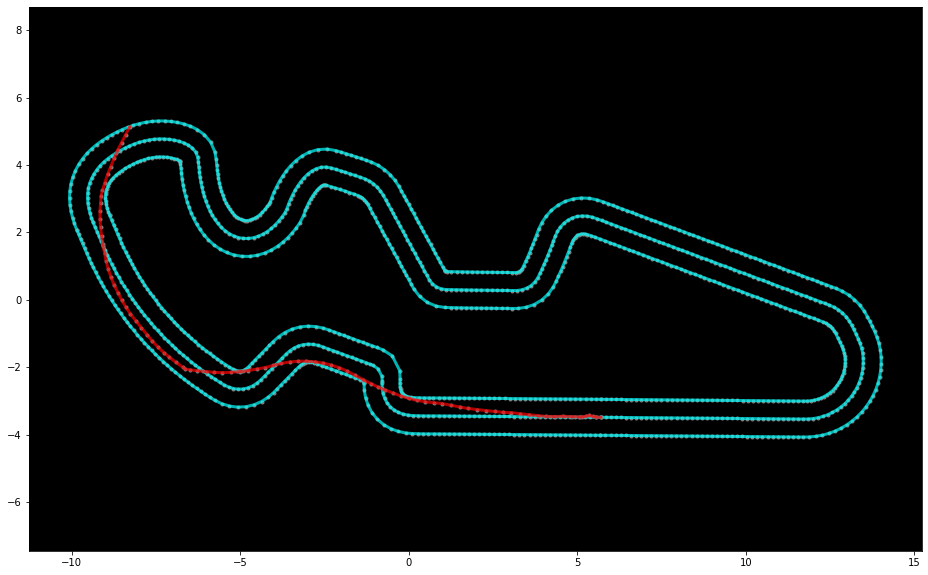

[======                                           ] 36.9%  5.63 sec/iter

Process ForkPoolWorker-1523:
Process ForkPoolWorker-1528:
Process ForkPoolWorker-1534:
Process ForkPoolWorker-1536:
Process ForkPoolWorker-1535:
Process ForkPoolWorker-1525:
Process ForkPoolWorker-1521:
Process ForkPoolWorker-1522:
Process ForkPoolWorker-1529:
Process ForkPoolWorker-1533:
Process ForkPoolWorker-1527:
Process ForkPoolWorker-1532:
Process ForkPoolWorker-1531:


KeyboardInterrupt: 

In [17]:
# A quick note about the parameters:
#  - n_laps : the number of laps for the race. Should not be finetuned
#  - n_individuals : number of individuals to compare for each epoch. The higher the better and slower
#  - percentage_mutations : percentage of the individual which will have mutations
#  - insertion_rate : rate of insertion (mutation can be either insertion or inplace modification)
#  - look_backward : portion of the track locally optimized. The higher the better and slower

# Note on insertion_rate : the number of insertion is ceiled. If we do 10 mutations and set insertion_rate to 0.05, there should be 1 (=np.ceil(10*0.05)) insertion

action_sequence = compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_individuals=1000,
    number_mutations=10,
    insertion_rate=0.5,
    cut_rate=2,
    look_backward=20,
)

### Plot the action sequence

In [ ]:
real_racing_line = compute_real_racing_line(
    action_sequence, 
    action_space, 
    x0=x0,
    y0=y0,
    theta0=theta0
)

In [ ]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)
# print_shape(ax, optimal_racing_line.drop(columns=['speed', 'distance_from_last_point']).values, color='green')
print_shape(ax, real_racing_line.values, color='red')

The blue line is the optimal racing line

The red line is the computed racing line, using only the actions from the action space

# Part 4 - Build the reward function

In [ ]:
#les reward élémentaires sont à valeur dans ]0,2]

eps = 1e-3

def reward_function(params):
    
    coeff_exit = 1
    coeff_comp = 1
    coeff_speed = 1
    coeff_steer = 1
    coeff_traj = 1
    
    optimal_racing_line = pd.DataFrame()
    
    exit_track_reward = coeff_exit * exit_track_reward(params)
    completion_reward = coeff_comp * completion_reward(params)
    opti_speed_reward = coeff_speed * opti_speed_reward(params,optimal_racing_line)
    opti_steering_reward = coeff_steer * opti_steering_reward(params,optimal_racing_line)
    opti_trajectory_reward = coeff_traj * opti_trajectory_reward(params,optimal_racing_line)
    
    reward = exit_track_reward + completion_reward + opti_speed_reward + opti_steering_reward + opti_trajectory_reward
    
    return float(reward)

def exit_track_reward(params):
    
    all_wheels_on_track = params['all_wheels_on_track']
    
    if (all_wheels_on_track):
        reward = 1
    else:
        reward = eps
    return float(reward)

def completion_reward(params):
    
    progress = params['progress']
    
    reward = eps+ progress/100.
    if (progress > 90):
        reward += 1
    return float(reward)

def opti_speed_reward(params,optimal_racing_line):
    
    speed = params['speed']
    progress = params['progress']
    
    opti_speed = optimal_racing_line['speed'].values[progress]
    reward = eps+1-abs(speed-opti_speed)/opti_speed
    return float(reward)

def opti_steering_reward(params,optimal_racing_line):
    
    steering_angle = params['steering_angle']
    progress = params['progress']
    
    opti_steering = optimal_racing_line['steering'].values[progress]
    reward = eps+1-abs(steering_angle-opti_steering)/opti_steering
    return float(reward)
    
def racing_trajectory_reward(params,optimal_racing_line):
    
    x,y = params['x'], params['y']
    progress = params['progress']
    
    opti_x = optimal_racing_line['x'].values[progress]
    opti_y = optimal_racing_line['y'].values[progress]
    reward = eps+1-np.sqrt((opti_x-x)**2+(opti_y-y)**2)/np.sqrt(opti_x**2+opti_y**2)
    return float(reward)
